In [12]:
project_name = '06-Gan_gpu-anime-faces'

In [13]:
!pip install opendatasets --upgrade --q

# Lets download the dataset from kaggle

In [15]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

  1%|▏         | 5.00M/395M [00:00<00:09, 42.7MB/s]

100%|██████████| 395M/395M [00:03<00:00, 129MB/s]


In [16]:
import os

Data_dir = './animefacedataset'
print(os.listdir(Data_dir))

['images']


In [17]:
print(os.listdir(Data_dir + '/images')[:10])

['59972_2018.jpg', '8833_2004.jpg', '13790_2006.jpg', '59505_2018.jpg', '35343_2011.jpg', '41432_2013.jpg', '19600_2007.jpg', '15099_2006.jpg', '51132_2015.jpg', '41951_2013.jpg']


In [18]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [19]:
image_size = 64
batch_size = 128
stats = (0.5,0.5,0.5),(0.5,0.5,0.5)  # means , standard_deviation

In [20]:
train_ds = ImageFolder(Data_dir, transform = T.Compose([T.Resize(image_size),
                                                        T.CenterCrop(image_size),
                                                        T.ToTensor(),
                                                        T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle =True, num_workers=3, pin_memory =True)

In [21]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

%matplotlib inline

In [22]:
tuple = (1,2,3),(4,5,6)

In [23]:
tuple[0][0]

1

In [24]:
def denorm(img_tensors):
    return img_tensors*stats[1][0] +stats[0][0]

In [25]:
for image,_ in train_dl :
    print(image.shape)
    break

torch.Size([128, 3, 64, 64])


In [26]:
image[0][0].shape

torch.Size([64, 64])

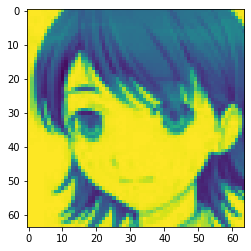

In [27]:
plt.imshow(denorm(image[0][0]))

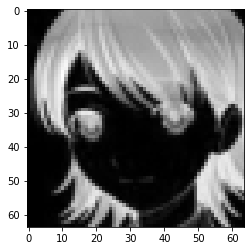

In [28]:
plt.imshow((-1)*image[0][0], cmap ='gray')

In [29]:
def show_images(images,nmax = 64):
    fig,ax = plt.subplots(figsize = (8,8))
    ax.set_xticks([]); ax.set_yticks([]);
    ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow = 8 ).permute(1,2,0))

def show_batch(dl,nmax = 64):
    for images, _ in dl:
        show_images(images,nmax)
        break

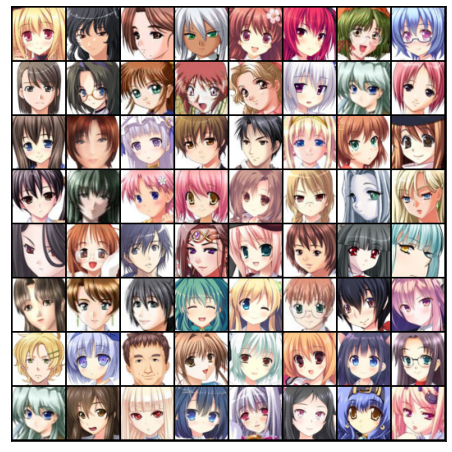

In [30]:
show_batch(train_dl)

In [31]:
jovian.commit(project = project_name)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/coolasit16/06-gan-gpu-anime-faces


'https://jovian.ai/coolasit16/06-gan-gpu-anime-faces'

# Run on gpu for faster training

In [44]:
def get_default_device():
    if torch.cuda.is_available():
       return torch.device('cuda')
    else:
       return torch.device('cpu')

def to_device(data,device):
    if isinstance(data, type([list,tuple])):
       return [to_device(x,device) for x in data]
    
    return data.to(device,non_blocking =True )

class DeviceDataLoader():
      def __init__(self,dl,device):
          self.dl = dl
          self.device = device

      def __iter__(self):
          for data in self.dl:
              yield to_device(data, self.device)

      def __len__(self):
          return len(self.dl)
      


In [45]:
device = get_default_device()
print(device)

cuda


In [46]:
train_dl = DeviceDataLoader(train_dl,device)

# lets create the generator model

In [47]:
import torch.nn as nn

In [48]:
discriminator = nn.Sequential(
    # input : batch_size * 3 * 64 * 64

    nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 4, stride = 2, padding=1,
              bias = False),
    nn.BatchNorm2d(num_features=64),
    nn.LeakyReLU(0.2, inplace =True),
    # out: batch-size* 64* 32 * 32

    nn.Conv2d(in_channels=64, out_channels=128, kernel_size = 4, stride =2, padding=1,
              bias= False),
    nn.BatchNorm2d(num_features=128),
    nn.LeakyReLU(0.2,inplace =True),
    #out: batch * 128 * 16 * 16

    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride = 2, padding =1,
              bias = False),
    nn.BatchNorm2d(num_features=256),
    nn.LeakyReLU(0.2,inplace =True),
    # out: batch * 256 *8 * 8

    nn.Conv2d(in_channels=256, out_channels=512, kernel_size =4, stride =2, padding = 1,
              bias =False),
    nn.BatchNorm2d(num_features=512),
    nn.LeakyReLU(0.2, inplace = True),
    #out : 512 * 4 * 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding =0, bias =False),
    # out : 1*1*1


    nn.Flatten(),
    nn.Sigmoid()
    )

In [49]:
# move the generator to 'gpu'
discriminator = to_device(discriminator, device)

In [50]:
latent_size = 128

In [51]:
generator = nn.Sequential(
    # in: latent * 1 *1
    nn.ConvTranspose2d(in_channels=latent_size, out_channels=512, kernel_size=4, stride=1,
                       padding=0,bias=False),
    nn.BatchNorm2d(num_features=512),
    nn.ReLU(True),
    # out : 512 * 4 * 4

    nn.ConvTranspose2d(in_channels=512,out_channels=256, kernel_size = 4, stride  =2,
                       padding = 1, bias = False),
    nn.BatchNorm2d(num_features=256),
    nn.ReLU(True),
    # out: 256*8*8

    nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, 
                       padding =1, bias=False),
    nn.BatchNorm2d(num_features=128),
    nn.ReLU(True),
    # out : 128*16*16

    nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2,
                       padding = 1, bias = False),
    nn.BatchNorm2d(num_features=64),
    nn.ReLU(True),
    # out : 64* 32*32
    
    nn.ConvTranspose2d(in_channels=64,out_channels=32, kernel_size=4, stride=2,
                       padding =1, bias  = False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # out : 32*64*64

    nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride =1, 
                       padding=1, bias = False),
    nn.Tanh()
    )

torch.Size([128, 3, 65, 65])


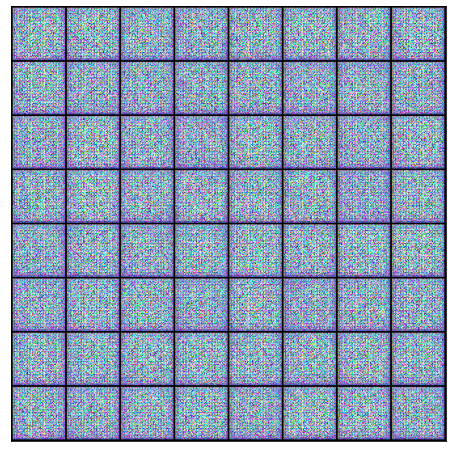

In [52]:
xb = torch.randn(batch_size,latent_size,1,1)  # random latent tensors 

fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

## Discriminator training

In [62]:
generator = to_device(generator, device)

In [79]:
def train_discriminator(real_images,opt_d):
    # clear discriminator gradients
    opt_d.zero_grad()

    # pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device = device)
    real_loss = F.binary_cross_entropy(real_preds,real_targets)
    real_score = torch.mean(real_preds).item()

    # generate fake images
    latent = torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images = generator(latent)

    # pass fake_images through discriminator
    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0),1,device=device)
    fake_loss = F.binary_cross_entropy(fake_preds,fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score


In [64]:
jovian.commit(project = project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/coolasit16/06-gan-gpu-anime-faces


'https://jovian.ai/coolasit16/06-gan-gpu-anime-faces'

# Train the generator 

In [92]:
def train_generator(opt_g):
    opt_g.zero_grad()

    # generate fake images
    latent = torch.randn(batch_size,latent_size,1,1,device =device)
    fake_images = generator(latent)

    # try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size,1,device= device)
    loss = F.binary_cross_entropy(preds,targets)


    # update generator weights 
    loss.backward()
    opt_g.step()

    return loss.item()


# lets capture the progress of the model

In [81]:
from torchvision.utils import save_image

In [82]:
sample_dir = 'generated'
os.makedirs(sample_dir,exist_ok = True)

In [71]:
def save_samples(index,latent_tensors,show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir,fake_fname),nrow=8)
    print('Saving', fake_fname)
    if show:
       fig,ax = plt.subplots(figsize= (8,8))
       ax.set_xticks([]); ax.set_yticks([]);
       ax.imshow(make_grid(fake_images.cpu().detach(),nrow = 8).permute(1,2,0))


In [69]:
fixed_latent = torch.randn(64,latent_size,1,1,device = device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


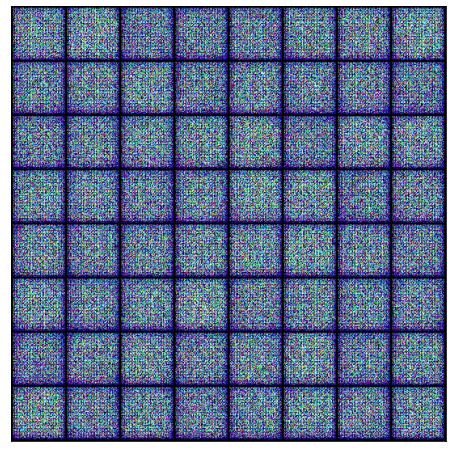

In [72]:
save_samples(0,fixed_latent)

In [83]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [96]:
def fit(epochs,lr,start_idx =1):
    torch.cuda.empty_cache()

    ## losses and scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(),lr=lr,betas=(0.5,0.999))
    opt_g = torch.optim.Adam(generator.parameters(),lr = lr, betas = (0.5,0.999))

    # iterations 
    for epoch in range(epochs):
        for real_images,_ in tqdm(train_dl):
            # train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images,opt_d) 
            # train generator
            loss_g = train_generator(opt_g)

         # record losses and scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

         # Log losses and scores
        print("Epoch[{}/{}], loss_g : {:.4f}, loss_d:{:.4f}, real_score:{:.4f},fake_score:{:.4f}"
        .format(epoch+1,epochs,loss_g,loss_d,real_score,fake_score))

         # Save generated images 
        save_samples(epoch+start_idx,fixed_latent,show=False)

    return losses_g,losses_d, real_scores, fake_scores
    




In [85]:
lr = 0.0002
epochs = 25

In [76]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs= epochs)

[jovian] Hyperparams logged.


In [97]:
history = fit(epochs,lr)


Epoch[1/25], loss_g : 7.0711, loss_d:0.4725, real_score:0.9428,fake_score:0.3189
Saving generated-images-0001.png



Epoch[2/25], loss_g : 5.4993, loss_d:0.4070, real_score:0.8074,fake_score:0.1166
Saving generated-images-0002.png



Epoch[3/25], loss_g : 4.4978, loss_d:0.5036, real_score:0.7020,fake_score:0.0156
Saving generated-images-0003.png



Epoch[4/25], loss_g : 5.3855, loss_d:0.3350, real_score:0.7738,fake_score:0.0112
Saving generated-images-0004.png



Epoch[5/25], loss_g : 12.9614, loss_d:1.0376, real_score:0.9974,fake_score:0.5606
Saving generated-images-0005.png



Epoch[6/25], loss_g : 4.5358, loss_d:0.2199, real_score:0.9168,fake_score:0.1105
Saving generated-images-0006.png



Epoch[7/25], loss_g : 6.0257, loss_d:0.0902, real_score:0.9794,fake_score:0.0635
Saving generated-images-0007.png



Epoch[8/25], loss_g : 3.4854, loss_d:0.5452, real_score:0.6715,fake_score:0.0131
Saving generated-images-0008.png



Epoch[9/25], loss_g : 4.5322, loss_d:0.1306, real_score:0.9559,fake_score:0.0724
Saving generated-images-0009.png



Epoch[10/25], loss_g : 5.9694, loss_d:0.3399, real_score:0.9219,fake_score:0.1811
Saving generated-images-0010.png



Epoch[11/25], loss_g : 5.6712, loss_d:0.4072, real_score:0.9750,fake_score:0.2650
Saving generated-images-0011.png



Epoch[12/25], loss_g : 3.6287, loss_d:0.3105, real_score:0.8875,fake_score:0.1437
Saving generated-images-0012.png



Epoch[13/25], loss_g : 6.5302, loss_d:0.3258, real_score:0.9859,fake_score:0.2324
Saving generated-images-0013.png



Epoch[14/25], loss_g : 5.0042, loss_d:0.2794, real_score:0.9274,fake_score:0.1498
Saving generated-images-0014.png



Epoch[15/25], loss_g : 4.8778, loss_d:0.2634, real_score:0.9438,fake_score:0.1593
Saving generated-images-0015.png



Epoch[16/25], loss_g : 3.4312, loss_d:0.2203, real_score:0.9059,fake_score:0.0951
Saving generated-images-0016.png



Epoch[17/25], loss_g : 4.9281, loss_d:0.1684, real_score:0.9639,fake_score:0.1104
Saving generated-images-0017.png



Epoch[18/25], loss_g : 5.5138, loss_d:0.2128, real_score:0.9802,fake_score:0.1605
Saving generated-images-0018.png



Epoch[19/25], loss_g : 2.0775, loss_d:0.4339, real_score:0.7192,fake_score:0.0231
Saving generated-images-0019.png



Epoch[20/25], loss_g : 4.3745, loss_d:0.2060, real_score:0.9539,fake_score:0.1252
Saving generated-images-0020.png



Epoch[21/25], loss_g : 3.5420, loss_d:0.1416, real_score:0.9321,fake_score:0.0629
Saving generated-images-0021.png



Epoch[22/25], loss_g : 3.8904, loss_d:0.1627, real_score:0.9315,fake_score:0.0759
Saving generated-images-0022.png



Epoch[23/25], loss_g : 4.7518, loss_d:0.3739, real_score:0.9858,fake_score:0.2531
Saving generated-images-0023.png



Epoch[24/25], loss_g : 4.2983, loss_d:0.5211, real_score:0.8837,fake_score:0.2704
Saving generated-images-0024.png



Epoch[25/25], loss_g : 1.7033, loss_d:1.0246, real_score:0.4726,fake_score:0.0044
Saving generated-images-0025.png


In [99]:
losses_g, losses_d, real_scores, fake_scores = history

In [100]:
jovian.log_metrics(loss_g=losses_g[-1],
                   loss_d = losses_d[-1],
                   real_score= real_scores[-1],
                   fake_score = fake_scores[-1])

[jovian] Metrics logged.


In [101]:
torch.save(generator.state_dict(),'G.pth')
torch.save(discriminator.state_dict(),'D.pth')

In [102]:
from IPython.display import Image

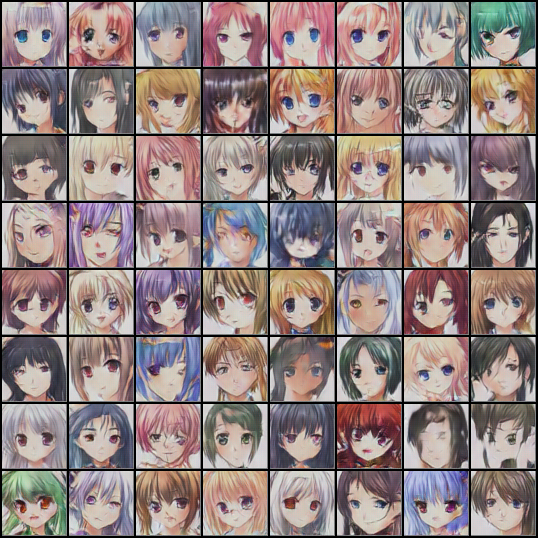

In [104]:
Image('./generated/generated-images-0025.png')

# creating  a video combining the images

In [108]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir,f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'),1,(530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [106]:
files

['generated/generated-images-0000.png',
 'generated/generated-images-0001.png',
 'generated/generated-images-0002.png',
 'generated/generated-images-0003.png',
 'generated/generated-images-0004.png',
 'generated/generated-images-0005.png',
 'generated/generated-images-0006.png',
 'generated/generated-images-0007.png',
 'generated/generated-images-0008.png',
 'generated/generated-images-0009.png',
 'generated/generated-images-0010.png',
 'generated/generated-images-0011.png',
 'generated/generated-images-0012.png',
 'generated/generated-images-0013.png',
 'generated/generated-images-0014.png',
 'generated/generated-images-0015.png',
 'generated/generated-images-0016.png',
 'generated/generated-images-0017.png',
 'generated/generated-images-0018.png',
 'generated/generated-images-0019.png',
 'generated/generated-images-0020.png',
 'generated/generated-images-0021.png',
 'generated/generated-images-0022.png',
 'generated/generated-images-0023.png',
 'generated/generated-images-0024.png',


# plot the losses

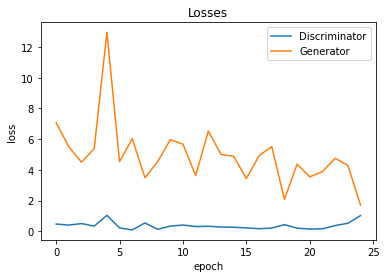

In [112]:
plt.plot(losses_d, '-')
plt.plot(losses_g,'-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator','Generator'])
plt.title('Losses');

Text(0.5, 1.0, 'Scores')

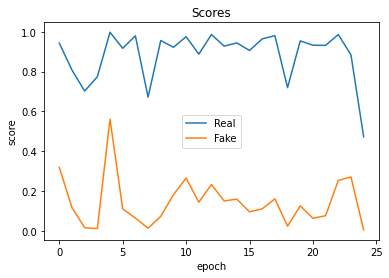

In [113]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')

In [118]:
jovian.commit(project = project_name,outputs = ['G.pth','D.pth', 'gans_training.avi','generated'],environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/coolasit16/06-gan-gpu-anime-faces


'https://jovian.ai/coolasit16/06-gan-gpu-anime-faces'

In [115]:
jovian.commit(outputs='generated')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/coolasit16/06-gan-gpu-anime-faces


'https://jovian.ai/coolasit16/06-gan-gpu-anime-faces'